In [120]:
## Realistic features - to scale, in target coordinates

In [121]:
# import packages
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker as mtick
from scipy import special

# append path for loading own packages
import sys
sys.path.append("../packages")

# switch on inline plotting
%matplotlib inline

### Measures / parameter set

**pitch**: Horizontal feature pattern length (50 nm, 100 nm, 400 nm)

**hfs**: Horizontal feature size (measured half height to half height, always 50 % of *pitch*)

**vfs**: Vertical feature size (measured from asymptotic bootom to asymptotic top, same as *hfs*)

In [122]:
pitch = [50e-9, 100e-9, 400e-9]
jitter_wavelength = [5e-9, 15e-9, 50e-9]

In [123]:
parameters = {}

# Horizontal feature pattern length in m
#pitch = np.array([50e-9, 100e-9, 400e-9])
parameters['pitch'] = 400e-9

# Horizontal feature size in m
parameters['hfs'] = 0.5 * parameters['pitch']

# Vertical feature size in m
parameters['vfs'] = 0.5 * parameters['pitch']

# Wavelength of jitter in m
parameters['jitter_wavelength'] = 200e-9

# Amplitude of jitter in m
parameters['jitter_amplitude'] = 0e-9

# Width of one feature edge in m
parameters['edge_width'] = 20e-9

# 3D density of silicon in electrons per m^3
dens3_silicon = 7e29

# 3D density of grating in electrons per m^3
parameters['dens3_grating'] = dens3_silicon

# 3D density of foil (without grating) in electrons per m^3
parameters['dens3_foil'] = dens3_silicon

# Focus size (edge length) in m
parameters['focus_size'] = 2e-6

# Number of incoming photons
parameters['Nin'] = 10e10

# Target array resolution
#resolution = np.array([64, 128, 256])
parameters['xres'] = 512

parameters['xmin'] = -0.5 * parameters['focus_size']
parameters['xmax'] =  0.5 * parameters['focus_size']

parameters['yres'] = 512
parameters['ymin'] = -0.5 * parameters['focus_size']
parameters['ymax'] =  0.5 * parameters['focus_size']

parameters['zres'] = 512
parameters['zmin'] = -0.5 * parameters['focus_size'] - np.sqrt(2)*parameters['vfs']
parameters['zmax'] =  0.5 * parameters['focus_size']

# Number of electrons in a cell of full density
parameters['nelectrons'] = (parameters['xmax'] - parameters['xmin']) *\
                           (parameters['ymax'] - parameters['ymin']) *\
                           (parameters['zmax'] - parameters['zmin']) *\
                            parameters['dens3_foil']

parameters['outfilename'] = "dummy.txt"

calc3d = False

In [124]:
# import own packages
import edges
import grating
import copy
from auxiliary import theta
import auxiliary as aux
import jitter
import density
import imaging as imgg

In [125]:
parameters['sigmaxp'] = 20e-9
parameters['sigmayp'] = 20e-9
parameters['nsigma']  = 2

parameters['sigmax']  = np.sqrt(2)*parameters['sigmaxp']
parameters['sigmay']  = parameters['sigmayp']

parameters['pixelsize'] = (parameters['xmax']-parameters['xmin'])/parameters['xres']

kernel_x = imgg.gaussian_kernel(parameters['sigmax'], 0, parameters['pixelsize'], parameters['nsigma'])
kernel_x_size = kernel_x.shape[0]
kernel_y = imgg.gaussian_kernel(0, parameters['sigmay'], parameters['pixelsize'], parameters['nsigma'])
kernel_y_size = kernel_y.shape[1]

parameters['xmin_guard'] = parameters['xmin'] - int((kernel_x_size-1)/2)*parameters['pixelsize']
parameters['xmax_guard'] = parameters['xmax'] + int((kernel_x_size  )/2)*parameters['pixelsize']
parameters['xres_guard'] = parameters['xres'] + kernel_x_size - 1
parameters['ymin_guard'] = parameters['ymin'] - int((kernel_y_size-1)/2)*parameters['pixelsize']
parameters['ymax_guard'] = parameters['ymax'] + int((kernel_y_size  )/2)*parameters['pixelsize']
parameters['yres_guard'] = parameters['yres'] + kernel_y_size - 1

print('xres_guard: {}'.format(parameters['xres_guard']))
print('yres_guard: {}'.format(parameters['yres_guard']))
print('kernel_x.shape : {}'.format(kernel_x.shape))
print('kernel_y.shape : {}'.format(kernel_y.shape))


xres_guard: 539
yres_guard: 531
kernel_x.shape : (28, 1)
kernel_y.shape : (1, 20)


In [126]:
def transpose_extent(a):
    return [a[2], a[3], a[0], a[1]]

### Make density function

In [127]:
edge             = edges.make_erf_edge(parameters['edge_width'], parameters['vfs'])
#edge             = edges.make_skewed_edge(parameters['edge_width'], parameters['vfs'])
#edge             = edges.make_perf_edge(parameters['edge_width'], parameters['vfs'])
feature          = grating.symm_feat(parameters['hfs'], edge)
grating_function = grating.feature_grating(parameters['pitch'], feature)
jitter_function  = jitter.make_jitter(parameters['jitter_amplitude'], parameters['jitter_wavelength'])
density_function = density.make_density(grating_function, jitter_function)

### Make 1D laser coordinate arrays

In [128]:
x_test = np.linspace(parameters['xmin'], parameters['xmax'], parameters['xres'])
y_test = np.linspace(parameters['ymin'], parameters['ymax'], parameters['yres'])
z_test = np.linspace(parameters['zmin'], parameters['zmax'], parameters['zres'])

x_guard = np.linspace(parameters['xmin_guard'], parameters['xmax_guard'], parameters['xres_guard'])
y_guard = np.linspace(parameters['ymin_guard'], parameters['ymax_guard'], parameters['yres_guard'])
z_guard = z_test

In [129]:
extent_laser_xy = [parameters['xmin'], parameters['xmax'],\
                   parameters['ymin'], parameters['ymax']]
extent_laser_xz = [parameters['xmin'], parameters['xmax'],\
                   parameters['zmin'], parameters['zmax']]
extent_laser_yz = [parameters['ymin'], parameters['ymax'],\
                   parameters['zmin'], parameters['zmax']]

### Make 1D target coordinate arrays

In [130]:
xpmin = aux.rcoords2tcoords(parameters['xmax'], 0, 0)[0]
xpmax = aux.rcoords2tcoords(parameters['xmin'], 0, 0)[0]
ypmin = aux.rcoords2tcoords(0, parameters['ymin'], 0)[1]
ypmax = aux.rcoords2tcoords(0, parameters['ymax'], 0)[1]
zpmin = aux.rcoords2tcoords(0, 0, parameters['zmax'])[2]
zpmax = aux.rcoords2tcoords(0, 0, parameters['zmin'])[2]

xp = np.linspace(xpmin, xpmax, parameters['xres'])
yp = np.linspace(ypmin, ypmax, parameters['yres'])
zp = np.linspace(zpmin, zpmax, parameters['zres'])

In [131]:
extent_target_xy = [xpmin, xpmin,\
                    ypmin, ypmin]
extent_target_xz = [xpmin, xpmin,\
                    zpmin, zpmin]
extent_target_yz = [ypmin, ypmin,\
                    zpmin, zpmin]

### Plot images for validation

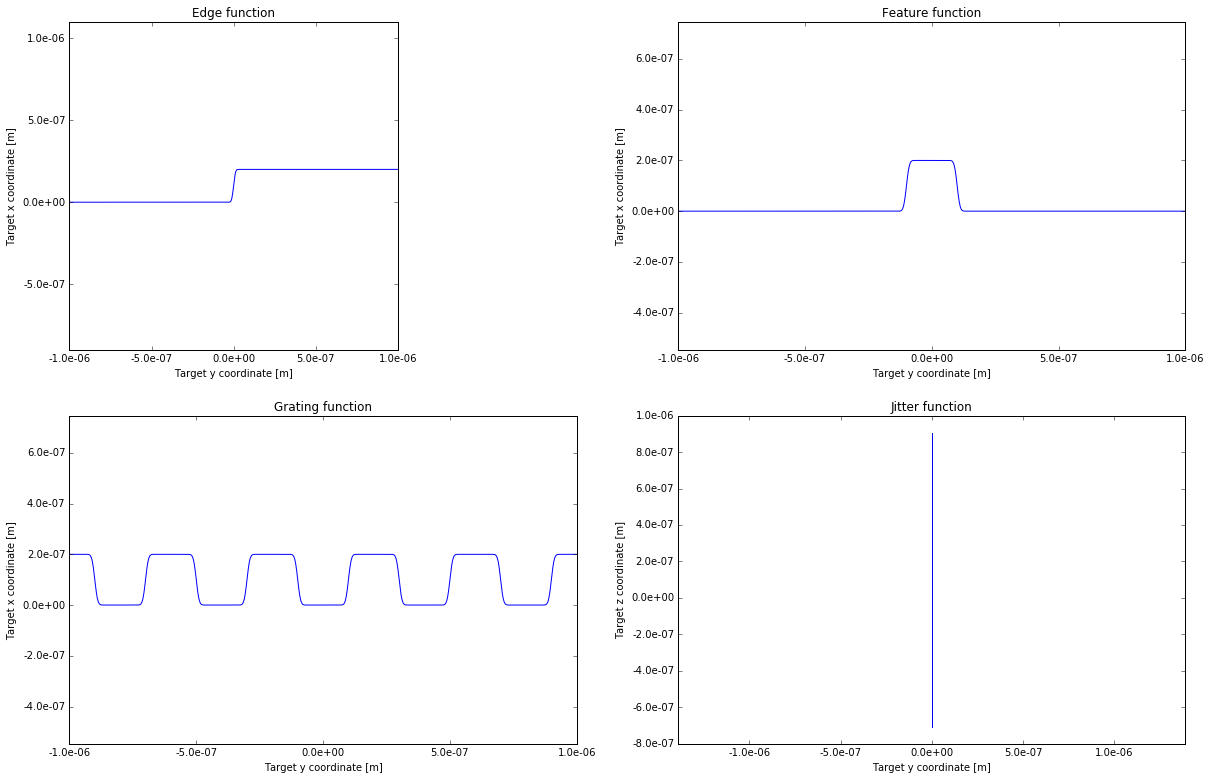

In [132]:
fig = plt.figure(figsize=(20,20))

sub1 = fig.add_subplot(3, 3, 1, adjustable='datalim', aspect=1.)
plt.plot(yp, edge(yp))
plt.title('Edge function')
plt.xlabel('Target y coordinate [m]')
plt.ylabel('Target x coordinate [m]')
sub1.get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
sub1.get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))

sub2 = fig.add_subplot(3, 2, 2, adjustable='datalim', aspect=1.)
plt.plot(yp, feature(yp))
plt.title('Feature function')
plt.xlabel('Target y coordinate [m]')
plt.ylabel('Target x coordinate [m]')
sub2.get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
sub2.get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))

sub3 = fig.add_subplot(3, 2, 3, adjustable='datalim', aspect=1.)
plt.plot(yp, grating_function(yp))
plt.title('Grating function')
plt.xlabel('Target y coordinate [m]')
plt.ylabel('Target x coordinate [m]')
sub3.get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
sub3.get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))

sub4 = fig.add_subplot(3, 2, 4, adjustable='datalim', aspect=1.)
plt.plot(jitter_function(zp), zp)
plt.title('Jitter function')
plt.xlabel('Target y coordinate [m]')
plt.ylabel('Target z coordinate [m]')
sub4.get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
sub4.get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))


### Calculate and sum density slices along z axis

In [133]:
xx, yy = np.meshgrid(x_guard, y_guard)

def dens2D (xx, yy, z):
    dd_sum = np.zeros(shape=[parameters['xres'], parameters['yres']])
    for z in z_test:
        xp, yp, zp = aux.rcoords2tcoords(xx, yy, z)
        dd = density_function(xp, yp, zp)
        dd, dde = imgg.smooth(dd, kernel_x.T, [parameters['xmin_guard'], parameters['xmax_guard'], parameters['ymin_guard'], parameters['ymax_guard']])
        dd, dde = imgg.smooth(dd, kernel_y.T, dde)
        dd_sum += dd
        
    return parameters['nelectrons'] * dd_sum

%time dd_sum = dens2D(xx, yy, z_guard)

CPU times: user 2min 1s, sys: 20 ms, total: 2min 1s
Wall time: 2min 1s


### Save summed density to file

In [134]:
path = parameters['outfilename']
if not aux.path_exists(path):
    np.savetxt(path, dd_sum)

### Plot summed density

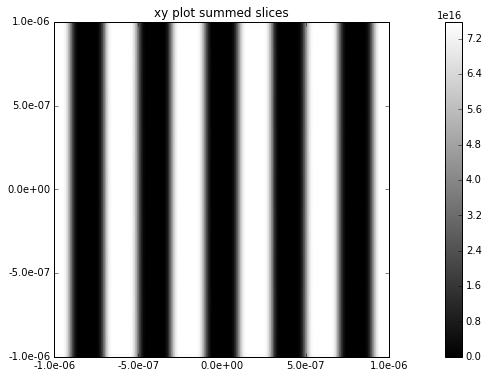

In [135]:
fig = plt.figure(figsize=(20, 6))
sub1 = fig.add_subplot(1, 1, 1)

aux.imshow(dd_sum.T, extent=transpose_extent(extent_laser_xy))
sub1.get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
sub1.get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
plt.title('xy plot summed slices')
plt.colorbar()

### Calculate 3D density grid

In [136]:
# Calculate 3D density grid
if calc3d:
    xxx, yyy, zzz = np.meshgrid(x_test, y_test, z_test)
    xxxp, yyyp, zzzp = aux.rcoords2tcoords(xxx, yyy, zzz)
    %time ddd = parameters['nelectrons'] * density_function(xxxp, yyyp, zzzp)
    
    print("done")
else:
    print("No 3D calculation")

No 3D calculation


Strange behavior - x and y axes seem swapped in the 3D array (?!)

### Plot slices of 3D density

In [137]:
if calc3d:
    fig = plt.figure(figsize=(20, 6))
    
    sub1 = fig.add_subplot(1, 3, 1)
    aux.imshow(ddd[:, :, len(z_test)//8].T, extent = transpose_extent(extent_laser_xy), origin='upper')
    sub1.get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    sub1.get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    plt.title('xy plot at 1/8 of z range')
    plt.colorbar()
    
    sub2 = fig.add_subplot(1, 3, 2)
    aux.imshow(ddd[:, :, len(z_test)//2].T, extent = transpose_extent(extent_laser_xy), origin='upper')
    sub2.get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    sub2.get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    plt.title('xy plot at 1/2 of z range')
    plt.colorbar()
    
    sub3 = fig.add_subplot(1, 3, 3)
    aux.imshow(ddd[:, :, len(z_test)//8*7].T, extent = transpose_extent(extent_laser_xy), origin='upper')
    sub3.get_xaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    sub3.get_yaxis().set_major_formatter(mtick.FormatStrFormatter('%.1e'))
    plt.title('xy plot at 7/8 of z range')
    plt.colorbar()
else:
    print("No 3D calculation")


No 3D calculation
